In [1]:
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import os
import scipy.signal as sgn
from tqdm import tqdm
from biosppy.signals import ecg
from scipy.signal import medfilt
from scipy.interpolate import CubicSpline

In [2]:
# get the list of files to be processed
ecgs_df = pd.read_csv("apnea-ecg-database-1.0.0\\list", header=None, names=['id'])
# add filepaths so we can retrieve the files later on
ecgs_df['filepath'] = ecgs_df['id'].apply(lambda x: str("apnea-ecg-database-1.0.0\\" + x))
# divide the dataset into train and test dataset as per instrucctions in the data set
ecgs_df['dataset'] = ecgs_df['id'].apply(lambda x: "test" if 'x' in x else "train")

In [3]:
# display the first 5 entries
ecgs_df.head()

,id,filepath,dataset
0,a01,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg-...,train
1,a02,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg-...,train
2,a03,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg-...,train
3,a04,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg-...,train
4,a05,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg-...,train


In [4]:
# display number of training and testing samples
freq = ecgs_df['dataset'].value_counts()
print(freq)

train    35
test     35
Name: dataset, dtype: int64


In [5]:
def load_ecg(file):
    # load the ecg

    # load the ecg
    record = wfdb.rdrecord(file)

    # load the annotation
    annotation = wfdb.rdann(file, extension="apn")

    # extract the signal
    p_signal = record.p_signal

    # verify frequency is 100
    assert record.fs == 100, 'sample freq is not 100'

    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample

    return p_signal, atr_sym, atr_sample

In [6]:
def build_XY(p_signal, df_ann, num_cols, abnormal, num_sec, fs):
    num_rows = len(df_ann)
    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows, 1))
    sym = []
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values, df_ann.atr_sym.values):
        left = max([0, (atr_sample - num_sec * fs)])
        right = min([len(p_signal), (atr_sample + num_sec * fs)])
        x = p_signal[left: right]

        # Debugging prints
        print(f"Left: {left}, Right: {right}, Segment Length: {len(x)}")

        if len(x) == num_cols:  # Ensure segment length matches expectation
            X[max_row, :] = x
            Y[max_row, :] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1

    X = X[:max_row, :]
    Y = Y[:max_row, :]
    print(len(x))
    return X, Y, sym


In [7]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output:
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)

    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []

    # list to keep track of number of beats across patients
    max_rows = []

    for pt in pts:
        file = pt

        p_signal, atr_sym, atr_sample = load_ecg(file)

        # grab the first signal
        p_signal = p_signal[:,0]

        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})

        X, Y, sym = build_XY(p_signal, df_ann, num_cols, abnormal, num_sec, fs)

        sym_all = sym_all +sym

        max_rows.append(X.shape[0])

        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)

    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]

    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

    return X_all, Y_all, sym_all

In [8]:
abnormal = ['A']


In [9]:
pts = ecgs_df[ecgs_df['dataset']=='train']


In [ ]:
x_train, y_train, sym_all = make_dataset(pts['filepath'], num_sec=10, fs=100, abnormal=abnormal)

In [11]:
pts_text = ecgs_df[ecgs_df['dataset']=='test']


In [ ]:
x_test, y_test, sym_all_test = make_dataset(pts['filepath'], num_sec=10, fs=100, abnormal=abnormal)


In [14]:
# Define function to plot some images
import matplotlib.pyplot as plt

def plot_ecgs(ecg, true_labels, class_names, start = 0 ):
    plt.figure(figsize=[12, 18])
    rows = 8
    columns = 2
    fig, ax = plt.subplots(rows, columns, figsize=(15, 15))
    index = start
    for i in range(rows):
        for j in range(columns):
            ax[i, j].plot(ecg[index])
            index = index+1
            #ax[i, j].set_ylim(ecg[i].min()-0.05,ecg[i].max()+0.05)
            ax[i, j].set_xlabel('time index')
            ax[i, j].set_ylabel('ECG signal')
            ax[i, j].set_title(class_names[int(true_labels[index])])

    plt.tight_layout()

In [ ]:
plot_ecgs(x_test, y_test, class_names = ['Normal','Apnea'], start=400)


In [13]:
values, counts = np.unique(sym_all, return_counts=True)


In [14]:
values, counts


(array(['A', 'N'], dtype='<U1'), array([ 6513, 10495], dtype=int64))

In [15]:
values, counts = np.unique(sym_all_test, return_counts=True)


In [16]:
values, counts


(array(['A', 'N'], dtype='<U1'), array([ 6513, 10495], dtype=int64))

In [ ]:
plt.figure(figsize=(5,5))
plt.pie(counts, labels=['0','1'], colors=['red','green'], autopct='%1.1f%%')
plt.show()

In [18]:
from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(X_all, Y_all, train_size = 0.8)

In [19]:
values, counts = np.unique(y_test, return_counts=True)


In [20]:
values, counts


(array([0., 1.]), array([10495,  6513], dtype=int64))

In [ ]:
plt.figure(figsize=(5,5))
plt.pie(counts, labels=['0','1'], colors=['red','green'], autopct='%1.1f%%')
plt.show()

In [22]:
values, counts = np.unique(y_train, return_counts=True)


In [23]:
values, counts


(array([0., 1.]), array([10495,  6513], dtype=int64))

In [ ]:
plt.figure(figsize=(5,5))
plt.pie(counts, labels=['0','1'], colors=['red','green'], autopct='%1.1f%%')
plt.show()

In [25]:
x_train.shape


(17008, 2000)

In [26]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)


In [27]:
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)


In [28]:
x_train.shape


(17008, 2000, 1)

In [29]:
import keras
from keras import models
from keras import layers

model = models.Sequential()

# CNN Layers
model.add(layers.Conv1D(64, 32, input_shape=(x_train.shape[1], x_train.shape[2]), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=4, strides=2, padding="same"))

model.add(layers.Conv1D(48, 32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides=2, padding="same"))

model.add(layers.Conv1D(48, 24, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Conv1D(32, 16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2, strides=2, padding="same"))

# Use pooling to reduce dimensions before LSTM
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Reshape((1, -1)))  # Reshape for LSTM input

# LSTM Layers
model.add(layers.LSTM(100, return_sequences=True))
model.add(layers.LSTM(100, return_sequences=True))
model.add(layers.LSTM(100))

# Dense Layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

print(model.summary())





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1969, 64)          2112      
                                                                 
 batch_normalization (Batch  (None, 1969, 64)          256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 985, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 954, 48)           98352     
                                                                 
 batch_normalization_1 (Bat  (None, 954, 48)           192       
 chNormalization)                                                
                                                     

In [30]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])


In [ ]:
from keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    '',  # Path where the model will be saved
    monitor='val_loss',
    save_best_only=True,  # Save only the best model
    mode='min',
    verbose=1
)

# Start training with the checkpoint
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=200,
    batch_size=512,
    callbacks=[checkpoint]  # Include checkpoint callback here
)

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc)+1)


NameError: name 'loss' is not defined

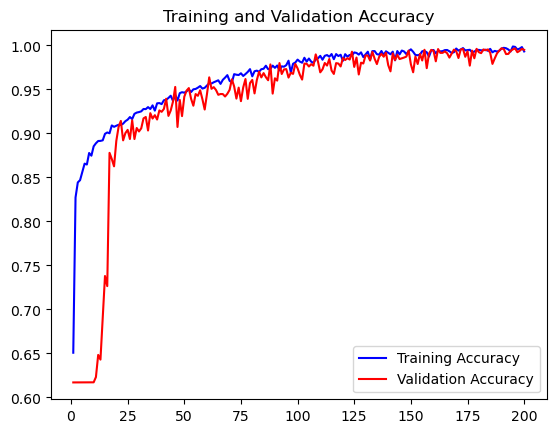

<Figure size 640x480 with 0 Axes>

In [37]:

# Plot accuracy
plt.figure()
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

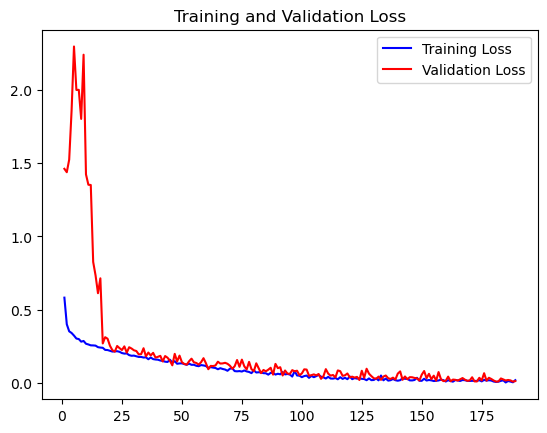

In [5]:
import matplotlib.pyplot as plt

epochs = list(range(1, 201))

# Truncate epochs to match the length of the available data
min_length = min(len(epochs), len(train_loss), len(val_loss))
epochs = epochs[:min_length]
# Ensure the lengths are consistent
train_loss = train_loss[:min_length]
val_loss = val_loss[:min_length]

# Plot loss
plt.figure()
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()


532/532 [==============================] - 30s 51ms/step


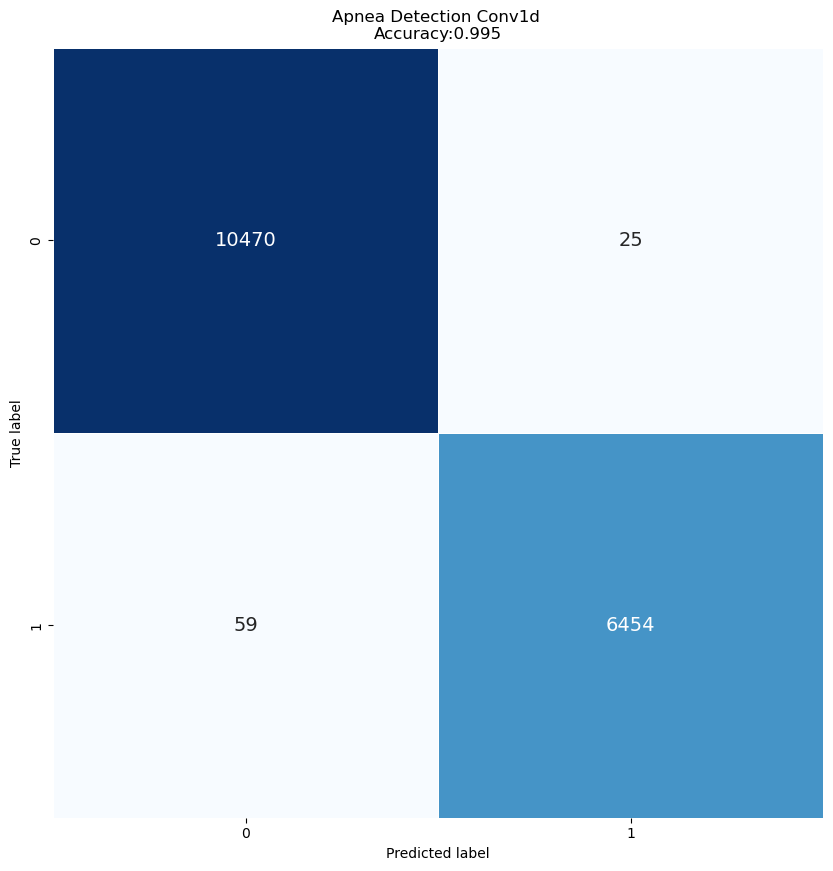

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns

y_pred = model.predict(x_test)
y_pred_classes = y_pred > 0.5

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred_classes) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index   = ['0', '1'], 
                     columns = ['0', '1'])

plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True, fmt="d", linewidths=0.5, cmap='Blues', cbar=False, annot_kws={'size':14}, square=True)
plt.title('Apnea Detection Conv1d \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred_classes)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

532/532 [==============================] - 37s 67ms/step

Model Evaluation Metrics:
Sensitivity/Recall: 0.9942
Specificity: 0.9982
Precision: 0.9971
F1-Score: 0.9956
Accuracy: 0.9966


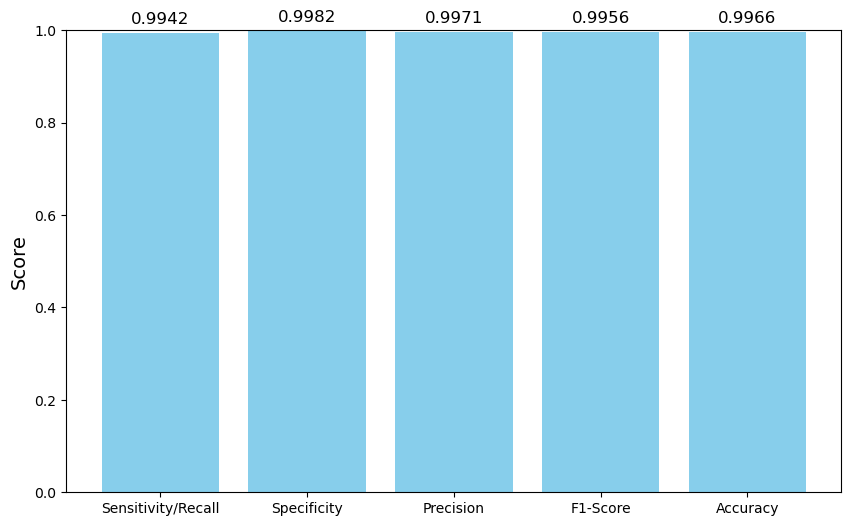

In [34]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

def calculate_metrics(checkpoint_path, test_data, test_labels):
    """
    Load a model from a checkpoint and calculate Sensitivity, Specificity, Precision, F1-score, and Accuracy.

    Args:
        checkpoint_path (str): Path to the model checkpoint.
        test_data (numpy.ndarray): Test data inputs.
        test_labels (numpy.ndarray): True labels for the test data.

    Returns:
        dict: A dictionary containing Sensitivity, Specificity, Precision, F1-score, and Accuracy.
    """
    # Load the model from the checkpoint
    model = tf.keras.models.load_model(checkpoint_path)

    # Make predictions
    predictions = model.predict(test_data)
    predicted_labels = (predictions > 0.5).astype(int).flatten()

    # Convert test_labels to 1D array if not already
    true_labels = test_labels.flatten()

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    tn, fp, fn, tp = cm.ravel()

    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_score = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    accuracy = (tp + tn) / (tp + fn + tn + fp) if (tp + fn + tn + fp) > 0 else 0

    metrics = {
        "Sensitivity/Recall": sensitivity,
        "Specificity": specificity,
        "Precision": precision,
        "F1-Score": f1_score,
        "Accuracy": accuracy
    }

    return metrics

def plot_metrics(metrics):
    """
    Plot the evaluation metrics.

    Args:
        metrics (dict): Dictionary containing evaluation metrics.
    """
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())

    plt.figure(figsize=(10, 6))
    plt.bar(metric_names, metric_values, color='skyblue')
    plt.ylabel('Score', fontsize=14)
    plt.ylim(0, 1)
    for i, v in enumerate(metric_values):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=12)
    plt.show()

# Example usage
if __name__ == "__main__":
    checkpoint_path = ""

    # Assuming x_test and y_test are already prepared
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)  # Ensure correct shape
    metrics = calculate_metrics(checkpoint_path, x_test, y_test)

    # Print metrics in a formatted way
    print("\nModel Evaluation Metrics:")
    print(f"Sensitivity/Recall: {metrics['Sensitivity/Recall']:.4f}")
    print(f"Specificity: {metrics['Specificity']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"F1-Score: {metrics['F1-Score']:.4f}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")

    # Plot metrics
    plot_metrics(metrics)
